**Loading the dataset and custom transforms**

https://docs.lightly.ai/tutorials/package/tutorial_simsiam_esa.html

***

***

# Split the dataset folder

In [1]:
import splitfolders

In [2]:
seed = 42
data_dir_initial = 'datasets/Sentinel2GlobalLULC_full_raw/Sentinel2LULC_JPEG/'

## Ratio

In [3]:
# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# splitfolders.ratio(data_dir_initial, output="datasets/Sentinel2GlobalLULC_ratio",
#                    seed=seed, ratio=(.7, .1, .2), group_prefix=None, move=False) # default values

## Balanced

In [4]:
#### Split val/test with a fixed number of items, e.g. `(100, 100)`, for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
# Set 3 values, e.g. `(300, 100, 100)`, to limit the number of training values.
# splitfolders.fixed(data_dir_initial, output="datasets/Sentinel2GlobalLULC_balanced",
#                    seed=seed, fixed=(400, 100), oversample=True, group_prefix=None, move=False) # default values

***

***

# Imports

In [5]:
import torch
import torchvision

import lightly
from lightly.models.modules.heads import SimSiamPredictionHead,SimSiamProjectionHead

import matplotlib.pyplot as plt
import numpy as np
import math
import random

/home/sfandres/Documents/Git/lulc/lulc-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Hyperparamenters.
input_size = 224  # input_size = 256
batch_size = 32   # batch_size = 128
num_workers = 8
epochs = 5

# Dimension of the embeddings.
num_ftrs = 512
# Dimension of the output of the prediction and projection heads.
out_dim = proj_hidden_dim = 512
# The prediction head uses a bottleneck architecture.
pred_hidden_dim = 128

# Seed torch and numpy.
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

***

***

# Loading dataset

In [7]:
data_dir = 'datasets/Sentinel2GlobalLULC_ratio'

## Custom tranforms

In [8]:
# Define the augmentations for self-supervised learning.
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.RandomResizedCrop(size=input_size, scale=(0.2, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.GaussianBlur(21),
    torchvision.transforms.ToTensor(),
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
])

## ImageFolder

In [9]:
# Loading both datasets.
train_data = torchvision.datasets.ImageFolder(data_dir + '/train/')

val_data = torchvision.datasets.ImageFolder(data_dir + '/val/')

test_data = torchvision.datasets.ImageFolder(data_dir + '/test/')

train_data_lightly = lightly.data.LightlyDataset.from_torch_dataset(train_data)
test_data_lightly = lightly.data.LightlyDataset.from_torch_dataset(test_data,
                                                                   transform=test_transform)

## Dataloaders

In [10]:
# Define the augmentations for self-supervised learning.
collate_fn_train = lightly.data.collate.BaseCollateFunction(train_transform)

# Create a dataloader for training and embedding.
dataloader_train_simsiam = torch.utils.data.DataLoader(
    train_data_lightly,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn_train,
    drop_last=True,
    num_workers=num_workers
)

dataloader_test = torch.utils.data.DataLoader(
    test_data_lightly,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

## Check balance and size

In [11]:
# Check samples per class in train dataset.
print(np.unique(train_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([9800, 3259, 6208, 9800, 8355, 3105,  943, 9800, 7306, 4466, 2015,
        396,  880, 9800, 2739, 2710, 9793,  291,  340, 2943, 9800, 9800,
       9800, 1402,  589,  714,  247,  289, 8813]))


In [12]:
# Check samples per class in val dataset.
print(np.unique(val_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([1400,  465,  886, 1400, 1193,  443,  134, 1400, 1043,  638,  288,
         56,  125, 1400,  391,  387, 1399,   41,   48,  420, 1400, 1400,
       1400,  200,   84,  102,   35,   41, 1259]))


In [13]:
print(len(train_data.targets))
print(len(val_data.targets))
print(len(test_data.targets))

136403
19478
38996


## See some samples

In [14]:
# import matplotlib.pyplot as plt


# # Accessing Data and Targets in a PyTorch DataLoader
# for images, labels, names in dataloader_train_simsiam:
#     img = images[0][0]
#     print(img.shape)
#     # img = images[0].squeeze()
#     # print(img)
#     label = labels[0]
#     plt.title("Label: " + str(int(label)))
#     plt.imshow(torch.permute(img,(1, 2, 0)))
#     plt.show()
#     break

In [15]:
# # Display image and label.
# train_features, train_labels = next(iter(dataloader_train_simsiam))

# print(f"Features shape of the current batch is {train_features.size()}")
# print(f"Labels shape of the current batch shape is {train_labels.size()}")

# img = train_features[0].squeeze()
# label = train_labels[0]
# plt.title("Label: " + str(int(label)))
# plt.imshow(torch.permute(img,(1, 2, 0)), cmap="gray")
# plt.show()
# print(f"Label: {label}")

# SimSiam model

## Creation

In [16]:
class SimSiam(torch.nn.Module):
    def __init__(
        self, backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim
    ):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimSiamProjectionHead(
            num_ftrs, proj_hidden_dim, out_dim
        )
        self.prediction_head = SimSiamPredictionHead(
            out_dim, pred_hidden_dim, out_dim
        )

    def forward(self, x):
        # get representations
        f = self.backbone(x).flatten(start_dim=1)
        # get projections
        z = self.projection_head(f)
        # get predictions
        p = self.prediction_head(z)
        # stop gradient
        z = z.detach()
        return z, p

In [17]:
# We use a pretrained resnet for this tutorial to speed
# up training time but you can also train one from scratch.
resnet = torchvision.models.resnet18(weights=None) # ADDED
backbone = torch.nn.Sequential(*list(resnet.children())[:-1])
model = SimSiam(backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim)

SimSiam uses a symmetric negative cosine similarity loss and does therefore not require any negative samples. We build a criterion and an optimizer.



In [18]:
from torchinfo import summary

summary(backbone, input_size=(batch_size, 3, input_size, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 512, 1, 1]           --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

## Training setup

In [19]:
# SimSiam uses a symmetric negative cosine similarity loss
criterion = lightly.loss.NegativeCosineSimilarity()

# scale the learning rate
lr = 0.05 * batch_size / 256
# use SGD with momentum and weight decay
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=5e-4
)

## Training

In [20]:
import time

### Loop

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

avg_loss = 0.
avg_output_std = 0.
for e in range(epochs):
    
    t0 = time.time()  # Added by me.

    for (x0, x1), _, _ in dataloader_train_simsiam:

        # move images to the gpu
        x0 = x0.to(device)
        x1 = x1.to(device)

        # run the model on both transforms of the images
        # we get projections (z0 and z1) and
        # predictions (p0 and p1) as output
        z0, p0 = model(x0)
        z1, p1 = model(x1)

        # apply the symmetric negative cosine similarity
        # and run backpropagation
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # calculate the per-dimension standard deviation of the outputs
        # we can use this later to check whether the embeddings are collapsing
        output = p0.detach()
        output = torch.nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        # use moving averages to track the loss and standard deviation
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

    # the level of collapse is large if the standard deviation of the l2
    # normalized output is much smaller than 1 / sqrt(dim)
    collapse_level = max(0., 1 - math.sqrt(out_dim) * avg_output_std)
    # print intermediate results
    print(f'[Epoch {e:3d}] '
          f'Loss = {avg_loss:.2f} | '
          f'Collapse Level: {collapse_level:.2f} / 1.00 | '
          f'Duration: {(time.time()-t0):.2f} s')

[Epoch   0] Loss = -0.98 | Collapse Level: 0.20 / 1.00 | Duration: 744.07 s
[Epoch   1] Loss = -0.98 | Collapse Level: 0.15 / 1.00 | Duration: 758.80 s
[Epoch   2] Loss = -0.98 | Collapse Level: 0.19 / 1.00 | Duration: 602.63 s
[Epoch   3] Loss = -0.98 | Collapse Level: 0.18 / 1.00 | Duration: 536.47 s
[Epoch   4] Loss = -0.98 | Collapse Level: 0.17 / 1.00 | Duration: 537.03 s


### Saving the pretrained model

In [22]:
torch.save(backbone.state_dict(), 'pytorch_models/simsiam_backbone_resnet18')

### Embeddings for the samples of the test dataset

In [23]:
embeddings = []
filenames = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):
        # move the images to the gpu
        x = x.to(device)
        # embed the images with the pre-trained backbone
        y = model.backbone(x).flatten(start_dim=1)
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

# Scatter Plot and Nearest Neighbors

In [24]:
# for plotting
import os
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp

# for resizing images to thumbnails
import torchvision.transforms.functional as functional

# for clustering and 2d representations
from sklearn import random_projection

In [25]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

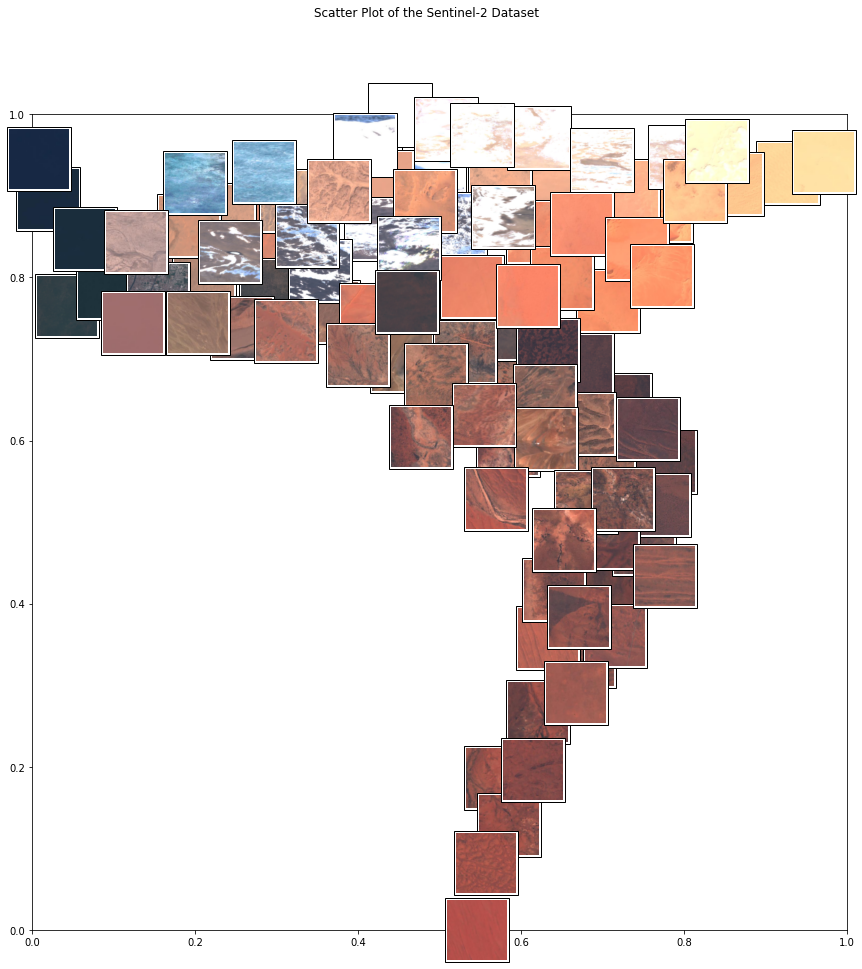

In [26]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays.
    """
    # initialize empty figure and add subplot
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle('Scatter Plot of the Sentinel-2 Dataset')
    ax = fig.add_subplot(1, 1, 1)
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # plot image overlays
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 10.)
        path = os.path.join(data_dir + '/test/', filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # set aspect ratio
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')


# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

In [27]:
# List of subdirectories (classes)
directory_list = []
for root, dirs, files in os.walk(data_dir + '/test/'):
    for dirname in sorted(dirs):
        directory_list.append(os.path.join(root, dirname))
        print(dirname)

# print(directory_list)

01_BarrenLands___jpeg
02_MossAndLichen_jpeg
03_Grasslands____jpeg
04_ShrublandOpen_jpeg
05_SrublandClose_jpeg
06_ForestsOpDeBr_jpeg
07_ForestsClDeBr_jpeg
08_ForestsDeDeBr_jpeg
09_ForestsOpDeNe_jpeg
10_ForestsClDeNe_jpeg
11_ForestsDeDeNe_jpeg
12_ForestsOpEvBr_jpeg
13_ForestsClEvBr_jpeg
14_ForestsDeEvBr_jpeg
15_ForestsOpEvNe_jpeg
16_ForestsClEvNe_jpeg
17_ForestsDeEvNe_jpeg
18_WetlandMangro_jpeg
19_WetlandSwamps_jpeg
20_WetlandMarshl_jpeg
21_WaterBodyMari_jpeg
22_WaterBodyCont_jpeg
23_PermanentSnow_jpeg
24_CropSeasWater_jpeg
25_CropCereaIrri_jpeg
26_CropCereaRain_jpeg
27_CropBroadIrri_jpeg
28_CropBroadRain_jpeg
29_UrbanBlUpArea_jpeg


In [28]:
example_images = []
for classes in directory_list:
    random_file = np.random.choice(os.listdir(classes))
    path_to_random_file = classes + '/' + random_file
    example_images.append(path_to_random_file[40:])
    print(path_to_random_file)

# example_images = example_images[:3]
# print(example_images)

datasets/Sentinel2GlobalLULC_ratio/test/01_BarrenLands___jpeg/1_BarrenLands___100.0__642612_1.8_(+35.9886662385,+96.6774095291)_CN_Qinghai-Sheng_nan_Zongjia.jpg
datasets/Sentinel2GlobalLULC_ratio/test/02_MossAndLichen_jpeg/2_MossAndLichen_91.4__3375_0.0_(+66.0110816860,-62.1476073120)_CA_Nunavut_nan_Pangnirtung.jpg
datasets/Sentinel2GlobalLULC_ratio/test/03_Grasslands____jpeg/3_Grasslands____100.0__4576_5.9_(+13.8340553754,+17.5767961751)_TD_Batha_nan_Ati.jpg
datasets/Sentinel2GlobalLULC_ratio/test/04_ShrublandOpen_jpeg/4_ShrublandOpen_95.1__97238_0.0_(-23.3317632113,+136.5999780598)_AU_Northern-Territory_Alice-Springs_Alice-Springs.jpg
datasets/Sentinel2GlobalLULC_ratio/test/05_SrublandClose_jpeg/5_SrublandClose_81.6__05855_14.4_(-35.5459764664,-67.5806181504)_AR_Mendoza_nan_General-Alvear.jpg
datasets/Sentinel2GlobalLULC_ratio/test/06_ForestsOpDeBr_jpeg/6_ForestsOpDeBr_80.5__3755_1.6_(-24.9817887252,+147.3251439000)_AU_Queensland_Central-Highlands_Emerald.jpg
datasets/Sentinel2Global

/tmp/ipykernel_50502/2553064624.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 10))


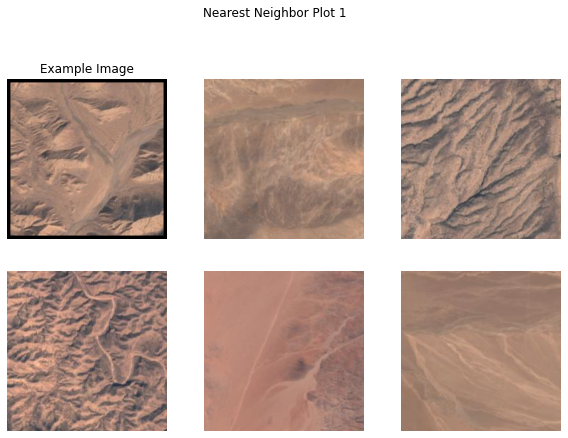

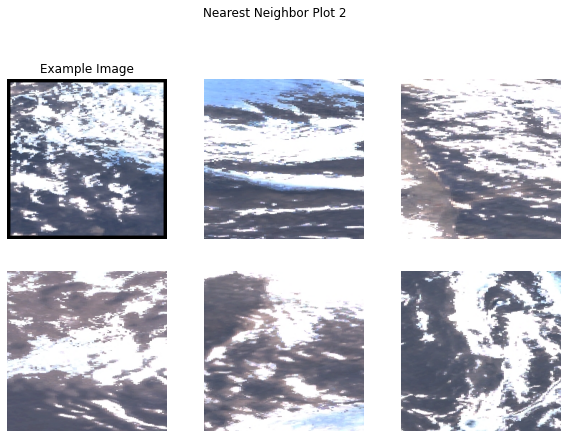

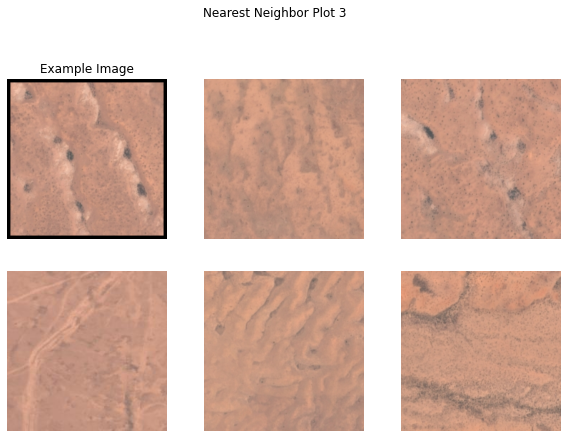

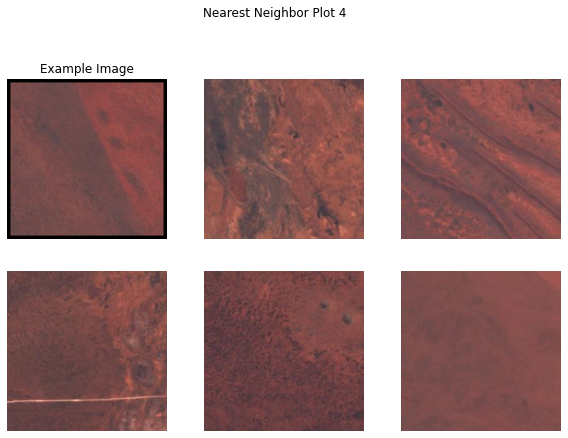

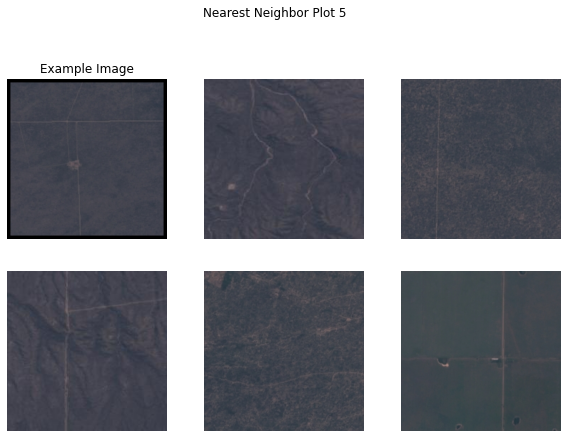

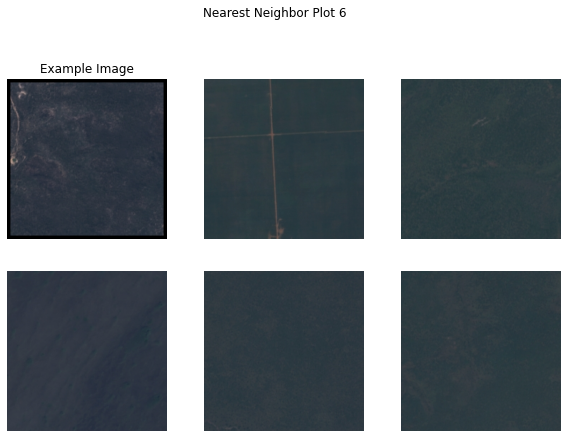

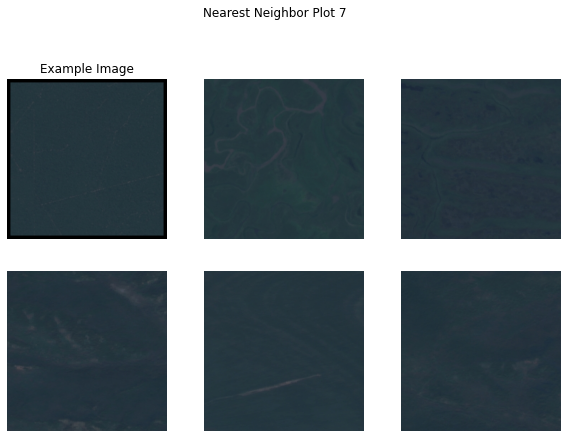

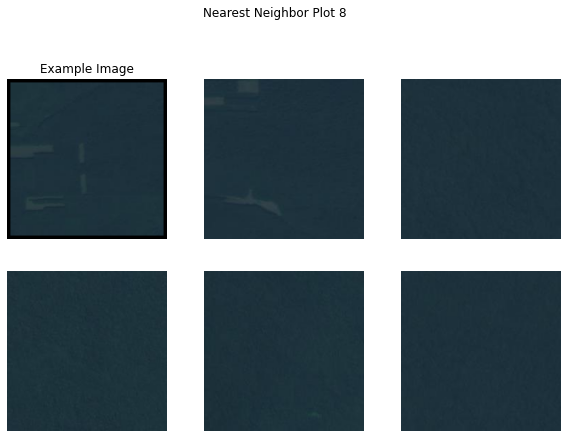

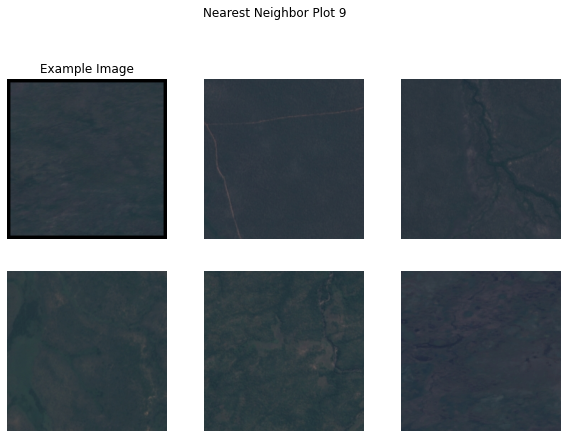

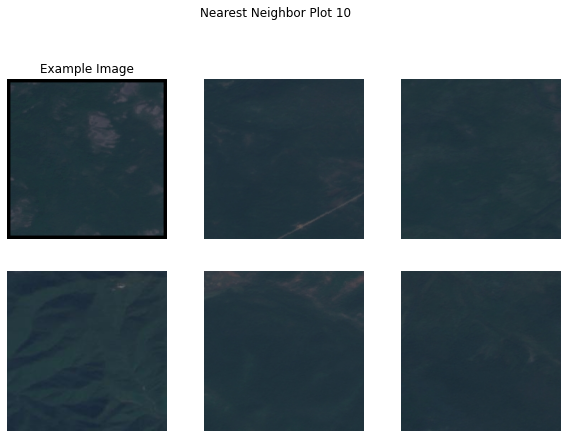

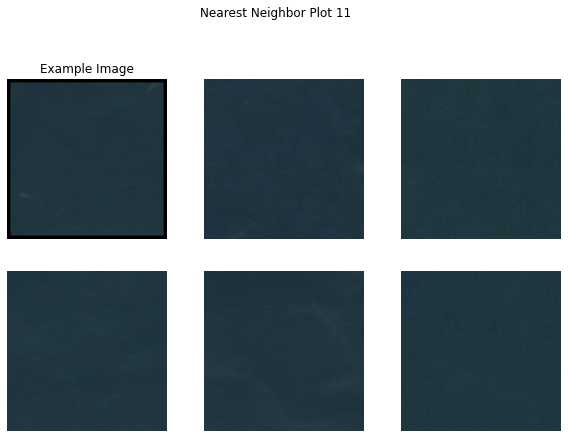

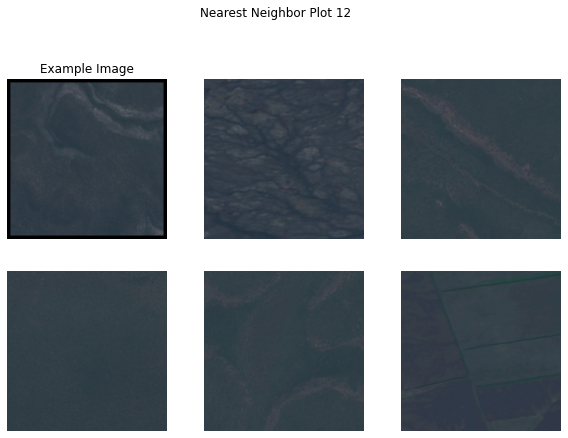

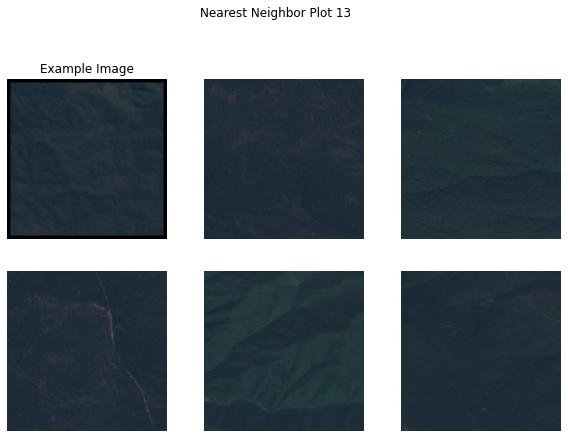

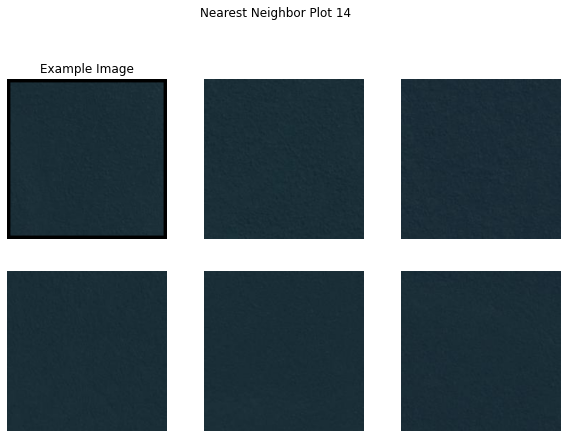

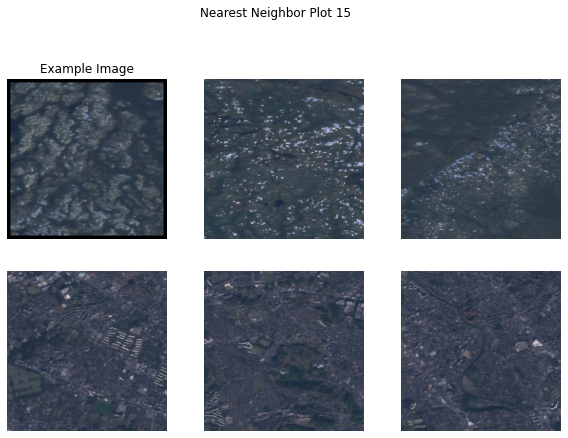

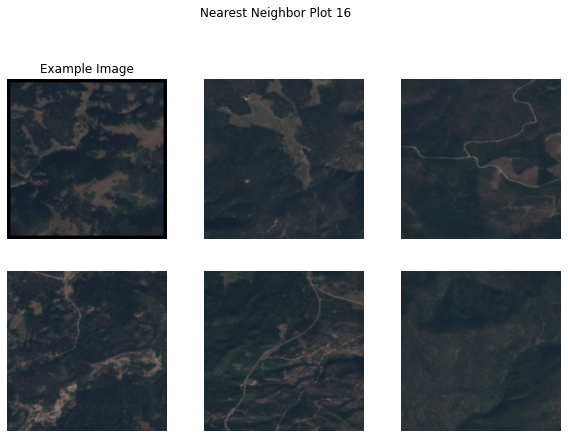

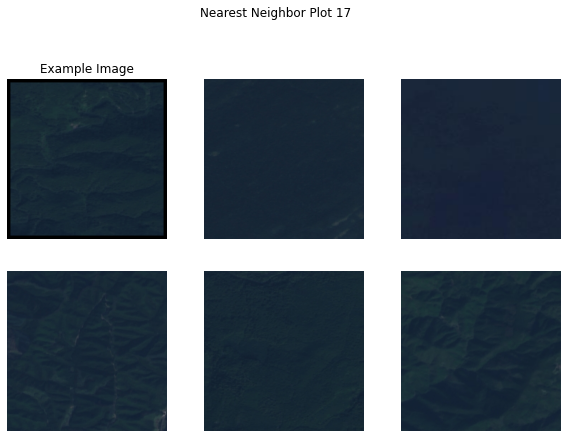

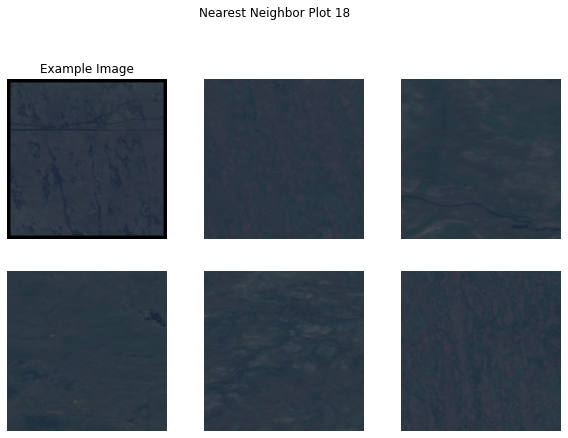

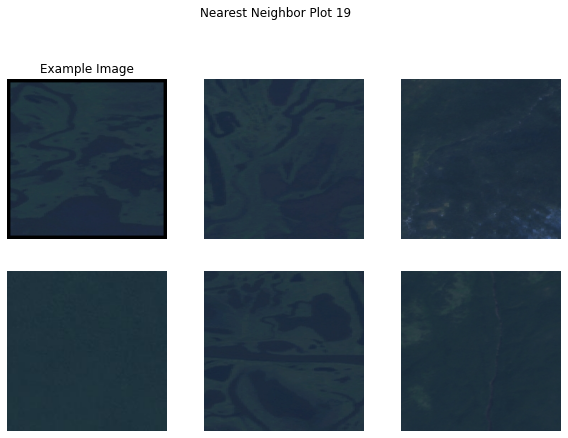

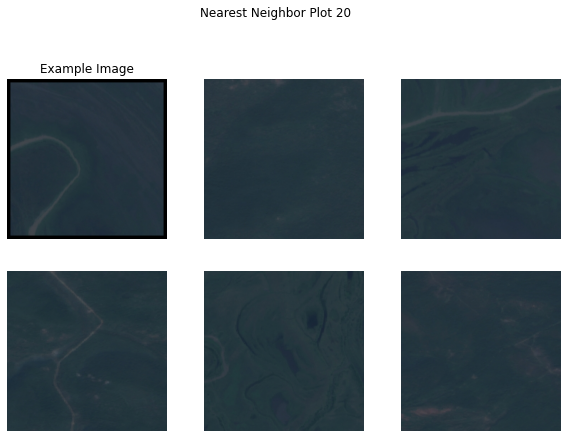

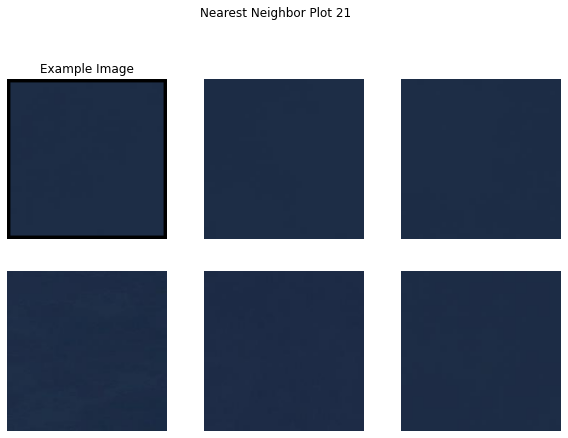

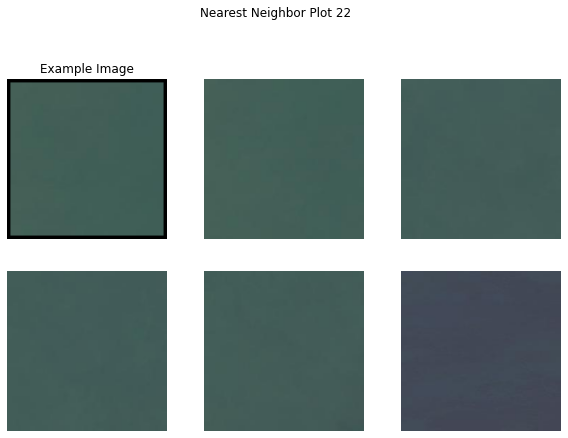

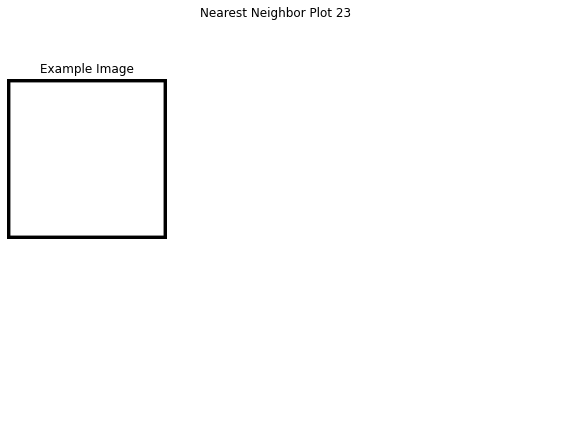

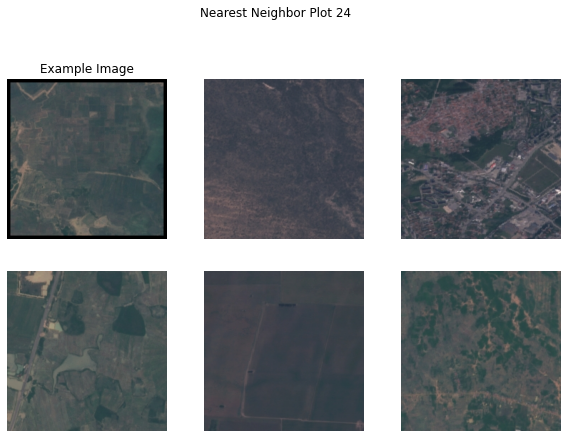

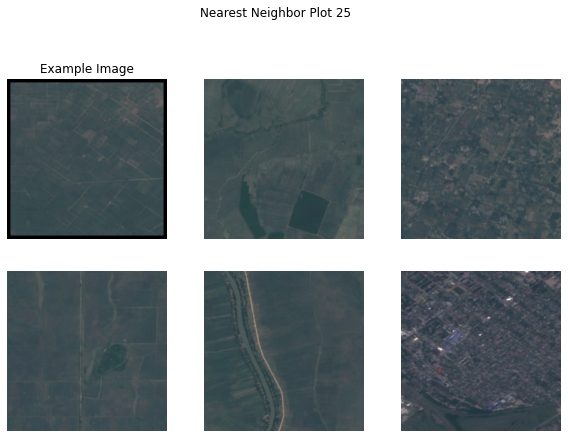

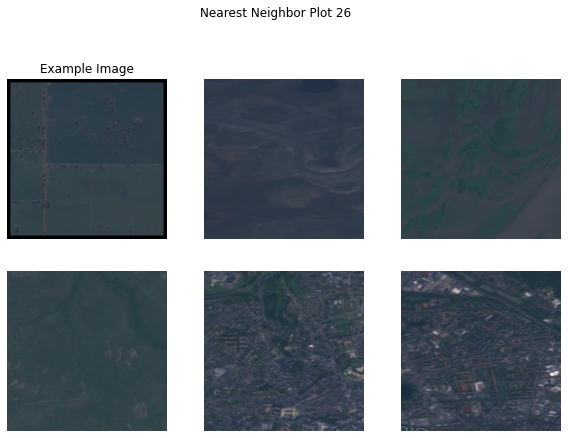

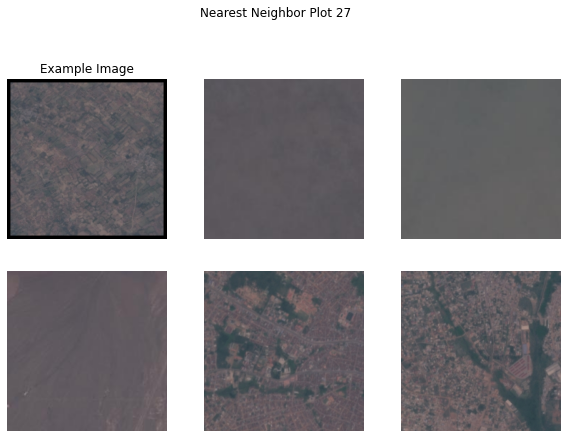

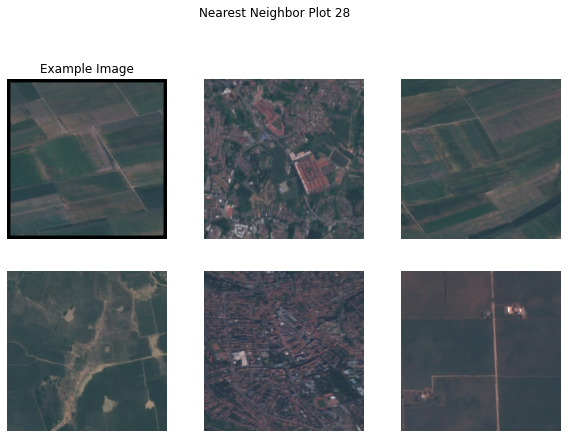

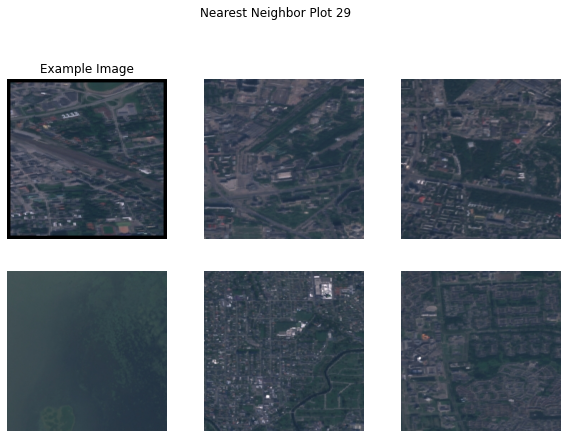

In [29]:
def get_image_as_np_array(filename: str):
    """
    Loads the image with filename and returns it as a numpy array.
    
    """
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """
    Returns an image as a numpy array with a black frame of width w.

    """
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape
    # create an empty image with padding for the frame
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)
    # put the original image in the middle of the new one
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_nxn(example_image: str, i: int):
    """
    Plots the example image and its eight nearest neighbors.

    """
    n_subplots = 6
    # initialize empty figure
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")
    #
    example_idx = filenames.index(example_image)
    # get distances to the cluster center
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()
    # sort indices by distance to the center
    nearest_neighbors = np.argsort(distances)[:n_subplots]
    # show images
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)
        # get the corresponding filename
        fname = os.path.join(data_dir + '/test/', filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Example Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))
        # let's disable the axis
        plt.axis("off")

# Show example images for each cluster.
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_nxn(example_image, i)